In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("../india-air-quality-2015-2020/Delhi/aqi_predicted.csv", parse_dates=["Datetime"])
# result = df[['AQI_calculated', 'AQI_bucket_calculated']]
# df = df.drop(columns=['AQI_calculated', 'AQI_bucket_calculated'])

In [4]:
df.columns.values

array(['Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'PM10_24hr_avg', 'PM2.5_24hr_avg', 'NO2_24hr_avg',
       'SO2_24hr_avg', 'NOx_24hr_avg', 'NH3_24hr_avg', 'CO_8hr_max',
       'O3_8hr_max', 'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex',
       'NOx_SubIndex', 'NH3_SubIndex', 'CO_SubIndex', 'O3_SubIndex',
       'Checks', 'AQI', 'AQI_bucket_calculated', 'AQI_predict',
       'AQI_predicted', 'Result', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33'], dtype=object)

In [9]:
aqi = df[["AQI_bucket_calculated", "AQI_predicted"]]
result = df["Result"]
aqi

,AQI_bucket_calculated,AQI_predicted
0,Severe,Severe
1,Severe,Severe
2,Severe,Severe
3,Severe,Severe
4,Severe,Severe
...,...,...
48172,Satisfactory,Satisfactory
48173,Satisfactory,Satisfactory
48174,Satisfactory,Satisfactory
48175,Satisfactory,Satisfactory


In [14]:
matching_count = (aqi['AQI_predicted'] == aqi['AQI_bucket_calculated']).sum()
mismatching_count = len(aqi['AQI_predicted']) - matching_count

In [23]:
counter = {
  "Matching": matching_count,
  "Mismatching": mismatching_count,
  "Original": len(aqi)
}

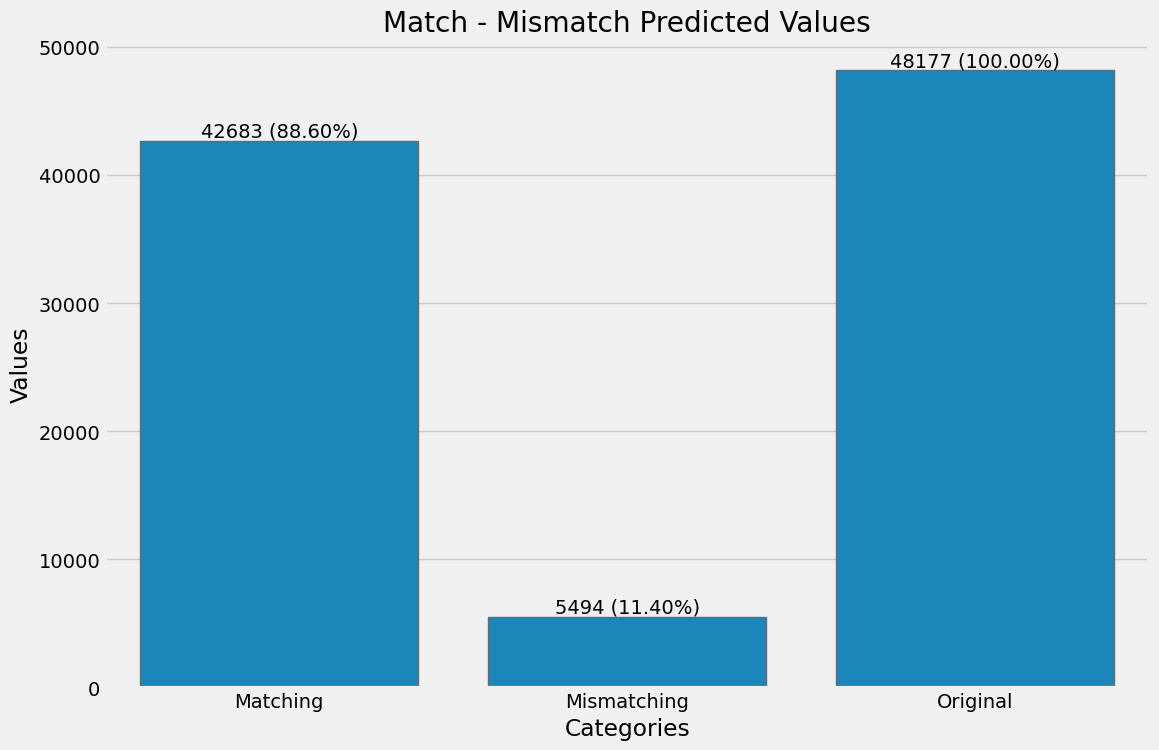

In [35]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(counter.items()), columns=["Category", "Value"])

plt.figure(figsize=(12,8))
# Create bar plot using Seaborn
sns.barplot(x="Category", y="Value", data=df)

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Match - Mismatch Predicted Values")

# # Annotate each bar with its value
# for index, value in enumerate(df["Value"]):
#     plt.text(index, value, str(value), ha="center", va="bottom")
# Annotate each bar with its value and percentage
for index, row in df.iterrows():
    value = row["Value"]
    percentage = (value / len(aqi)) * 100
    plt.text(index, value, f"{value} ({percentage:.2f}%)", ha="center", va="bottom")

# Show plot
plt.show()

In [26]:
# Count occurrences of each unique value in 'Column1'
predicted_value_counts = aqi['AQI_predicted'].value_counts()
original_value_counts = aqi['AQI_bucket_calculated'].value_counts()

print("Occurrences of each unique value in 'Column1':")
print(original_value_counts)
print(predicted_value_counts)

Occurrences of each unique value in 'Column1':
AQI_bucket_calculated
Moderate        14872
Very Poor       14398
Poor             9229
Satisfactory     4983
Severe           4342
Good              353
Name: count, dtype: int64
AQI_predicted
Moderate        15198
Very Poor       12554
Poor            11713
Satisfactory     5290
Severe           3069
Good              353
Name: count, dtype: int64


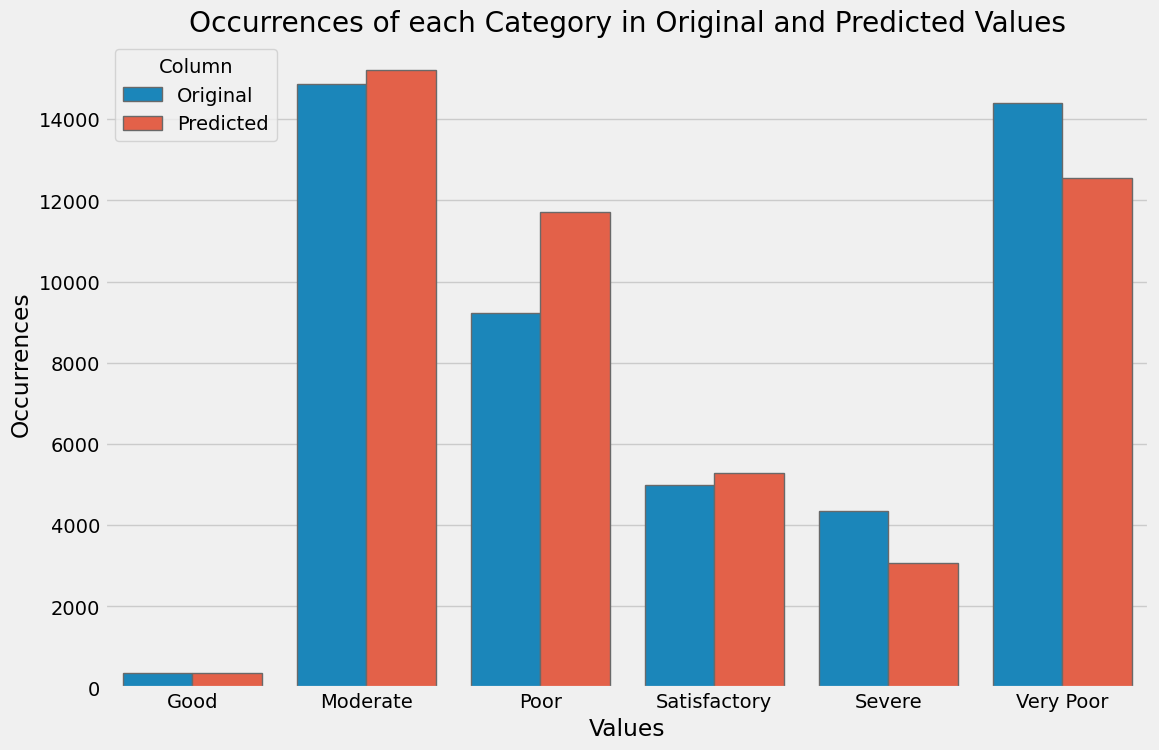

In [37]:
# Concatenate 'original' and 'predicted' columns
combined_series = pd.concat([aqi["AQI_bucket_calculated"], aqi["AQI_predicted"]])

# Count occurrences of each unique value in 'original' and 'predicted' columns
original_counts = aqi["AQI_bucket_calculated"].value_counts().sort_index()
predicted_counts = aqi["AQI_predicted"].value_counts().sort_index()

# Create a DataFrame to store the counts for each category
category_counts = pd.DataFrame(
    {
        "Value": original_counts.index,
        "Original": original_counts.values,
        "Predicted": predicted_counts.values,
    }
)

# Melt the DataFrame to long format for plotting
category_counts = pd.melt(
    category_counts, id_vars=["Value"], var_name="Column", value_name="Occurrences"
)

plt.figure(figsize=(12, 8))

# Create bar plot using Seaborn
sns.barplot(x="Value", y="Occurrences", hue="Column", data=category_counts)

# Annotate each bar with its value
# for index, row in category_counts.iterrows():
#     plt.text(
#         index, row["Occurrences"], f"{row['Occurrences']}", color="black", ha="center"
#     )

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Occurrences")
plt.title("Occurrences of each Category in Original and Predicted Values")


# Show plot
plt.show()

In [32]:
category_counts

,Value,Column,Occurrences
0,Good,Original,353
1,Moderate,Original,14872
2,Poor,Original,9229
3,Satisfactory,Original,4983
4,Severe,Original,4342
5,Very Poor,Original,14398
6,Good,Predicted,353
7,Moderate,Predicted,15198
8,Poor,Predicted,11713
9,Satisfactory,Predicted,5290


## Predict

In [45]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["AQI_bucket_predicted"] = df["AQI_predict"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,PM10_24hr_avg,PM2.5_24hr_avg,NO2_24hr_avg,SO2_24hr_avg,NOx_24hr_avg,NH3_24hr_avg,CO_8hr_max,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated,AQI_predict,AQI_bucket_predicted
0,2015-01-01 16:00:00,211.51,340.66,13.09,37.08,47.07,33.54,15.24,12.33,34.35,681.438437,323.240000,32.892500,6.288750,93.116875,30.975000,24.15,55.49,456.338461,714.298047,7.860938,113.116875,7.743750,342.058824,55.49,7,714,Severe,636.73720,Severe
1,2015-01-01 17:00:00,191.12,257.40,15.44,38.40,51.24,34.98,13.11,18.00,34.38,656.495000,315.468235,33.216471,6.977647,90.653529,31.210588,24.15,55.49,450.360181,683.118750,8.722059,110.653529,7.802647,342.058824,55.49,7,683,Severe,612.63200,Severe
2,2015-01-01 18:00:00,218.44,351.01,22.85,44.73,59.26,34.80,18.35,19.17,38.42,639.523611,310.077778,33.856111,7.655000,88.909444,31.410000,24.15,55.49,446.213675,661.904514,9.568750,108.909444,7.852500,342.058824,55.49,7,662,Severe,596.13416,Severe
3,2015-01-01 19:00:00,296.80,600.95,69.20,47.76,101.68,34.25,16.67,21.50,49.12,637.493421,309.378947,34.587895,8.383684,89.581579,31.559474,24.15,53.17,445.676113,659.366776,10.479605,109.581579,7.889868,342.058824,53.17,7,659,Severe,593.76670,Severe
4,2015-01-01 20:00:00,336.43,714.63,148.42,46.31,171.10,35.75,12.17,17.67,56.44,641.350250,310.731500,35.174000,8.848000,93.657500,31.769000,24.15,56.44,446.716539,664.187812,11.060000,113.657500,7.942250,342.058824,56.44,7,664,Severe,597.71140,Severe
5,2015-01-01 21:00:00,326.64,691.84,181.10,44.33,200.68,30.94,9.03,13.67,47.73,643.754524,311.489048,35.610000,9.077619,98.753810,31.729524,24.15,56.44,447.299267,667.193155,11.347024,118.753810,7.932381,342.058824,56.44,7,667,Severe,600.07500,Severe
6,2015-01-01 22:00:00,327.68,732.59,129.53,43.87,226.67,53.74,13.66,12.00,48.34,647.792500,312.225000,35.985455,9.210455,104.568182,32.730000,24.15,56.44,447.865385,672.240625,11.513068,124.568182,8.182500,342.058824,56.44,7,672,Severe,604.00757,Severe
7,2015-01-01 23:00:00,335.18,776.36,147.06,45.35,243.13,58.59,12.20,10.17,44.82,653.382391,313.223044,36.392609,9.252174,110.592609,33.854348,18.35,56.44,448.633110,679.227989,11.565217,130.592609,8.463587,307.941176,56.44,7,679,Severe,609.50010,Severe
8,2015-01-02 00:00:00,358.68,860.32,153.72,43.71,245.21,63.71,20.02,7.00,54.32,662.004792,315.117083,36.697500,9.158333,116.201667,35.098333,20.02,56.44,450.090064,690.005990,11.447917,136.201667,8.774583,317.764706,56.44,7,690,Severe,618.10070,Severe
9,2015-01-02 01:00:00,444.44,806.07,199.28,44.46,215.59,4.00,27.20,5.17,60.05,656.625208,314.694583,36.809167,9.231667,117.365417,34.117500,27.20,60.05,449.765064,683.281510,11.539583,137.365417,8.529375,360.000000,60.05,7,683,Severe,612.63200,Severe


In [46]:
df.to_csv("../india-air-quality-2015-2020/Delhi/aqi_predicted.csv", index=False)

In [ ]:
df['Date']=df["Datetime"].dt.date
df['Month']=df["Datetime"].dt.month
df['Year']=df["Datetime"].dt.year
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day

In [ ]:
df.info()

In [4]:
df = df[
    ["Datetime", "O3", "CO", "NO2", "SO2", "NO", "NOx", "PM2.5", "PM10", "NH3","AQI_calculated"]
]
df2 = df.groupby(["Datetime"]).mean()
df2.head()

,O3,CO,NO2,SO2,NO,NOx,PM2.5,PM10,NH3,AQI_calculated
Datetime,,,,,,,,,,
2015-01-01 16:00:00,34.35,15.24,37.08,12.33,13.09,47.07,211.51,340.66,33.54,714.0
2015-01-01 17:00:00,34.38,13.11,38.40,18.00,15.44,51.24,191.12,257.40,34.98,683.0
2015-01-01 18:00:00,38.42,18.35,44.73,19.17,22.85,59.26,218.44,351.01,34.80,662.0
2015-01-01 19:00:00,49.12,16.67,47.76,21.50,69.20,101.68,296.80,600.95,34.25,659.0
2015-01-01 20:00:00,56.44,12.17,46.31,17.67,148.42,171.10,336.43,714.63,35.75,664.0


# AQI Prediction

In [10]:
# log transformation to deal with skewed data

aqi = np.log1p(df2[['AQI_calculated']].values)
aqi.shape

(48177, 1)

<Figure size 1200x500 with 0 Axes>

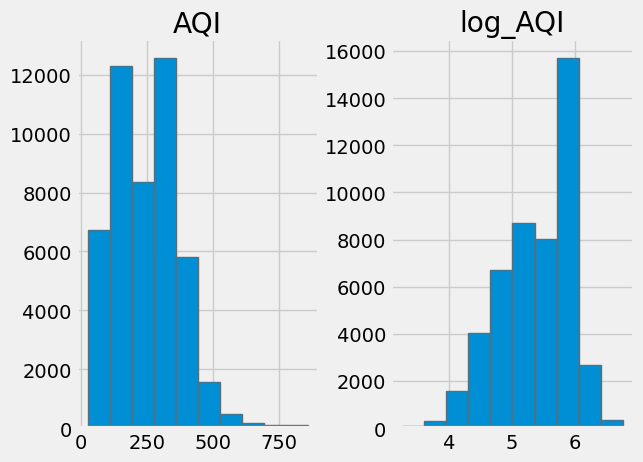

In [11]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'AQI' : df2['AQI_calculated'].values, 'log_AQI' : aqi[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [12]:
# split into train and test sets
# 80% for training, 20% for testing

train_size = int(len(aqi) * 0.8)
test_size = len(aqi) - train_size
train, test = aqi[0:train_size, :], aqi[train_size : len(aqi), :]
print(len(train), len(test))

38541 9636


In [13]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print("Shape of trainX :", trainX.shape)
print("Shape of trainY :", trainY.shape)
print("Shape of testX :", testX.shape)
print("Shape of testY :", testY.shape)

Shape of trainX : (38539, 1)
Shape of trainY : (38539,)
Shape of testX : (9634, 1)
Shape of testY : (9634,)


In [17]:
# reshape the input array to be [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("Shape of trainX :", trainX.shape)
print("Shape of testX :", testX.shape)

Shape of trainX : (38539, 1, 1)
Shape of testX : (9634, 1, 1)


In [18]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, batch_size=1, epochs=1)




38539/38539 [==============================] - 230s 6ms/step - loss: 0.0208


In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

302/302 [==============================] - 1s 4ms/step
Train Score: 17.71 RMSE
Test Score: 12.51 RMSE


In [20]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
12.51 < 121.33


In [42]:
train_aqi = pd.DataFrame(trainPredict, columns=['AQI'])
test_aqi = pd.DataFrame(testPredict, columns =['AQI'])
print(len(train_aqi))
print(len(test_aqi))

38539
9634


In [41]:
train_aqi.to_csv("../india-air-quality-2015-2020/Delhi/train_aqi.csv", index=False)
test_aqi.to_csv("../india-air-quality-2015-2020/Delhi/test_aqi.csv", index=False)

(38000.0, 49000.0)

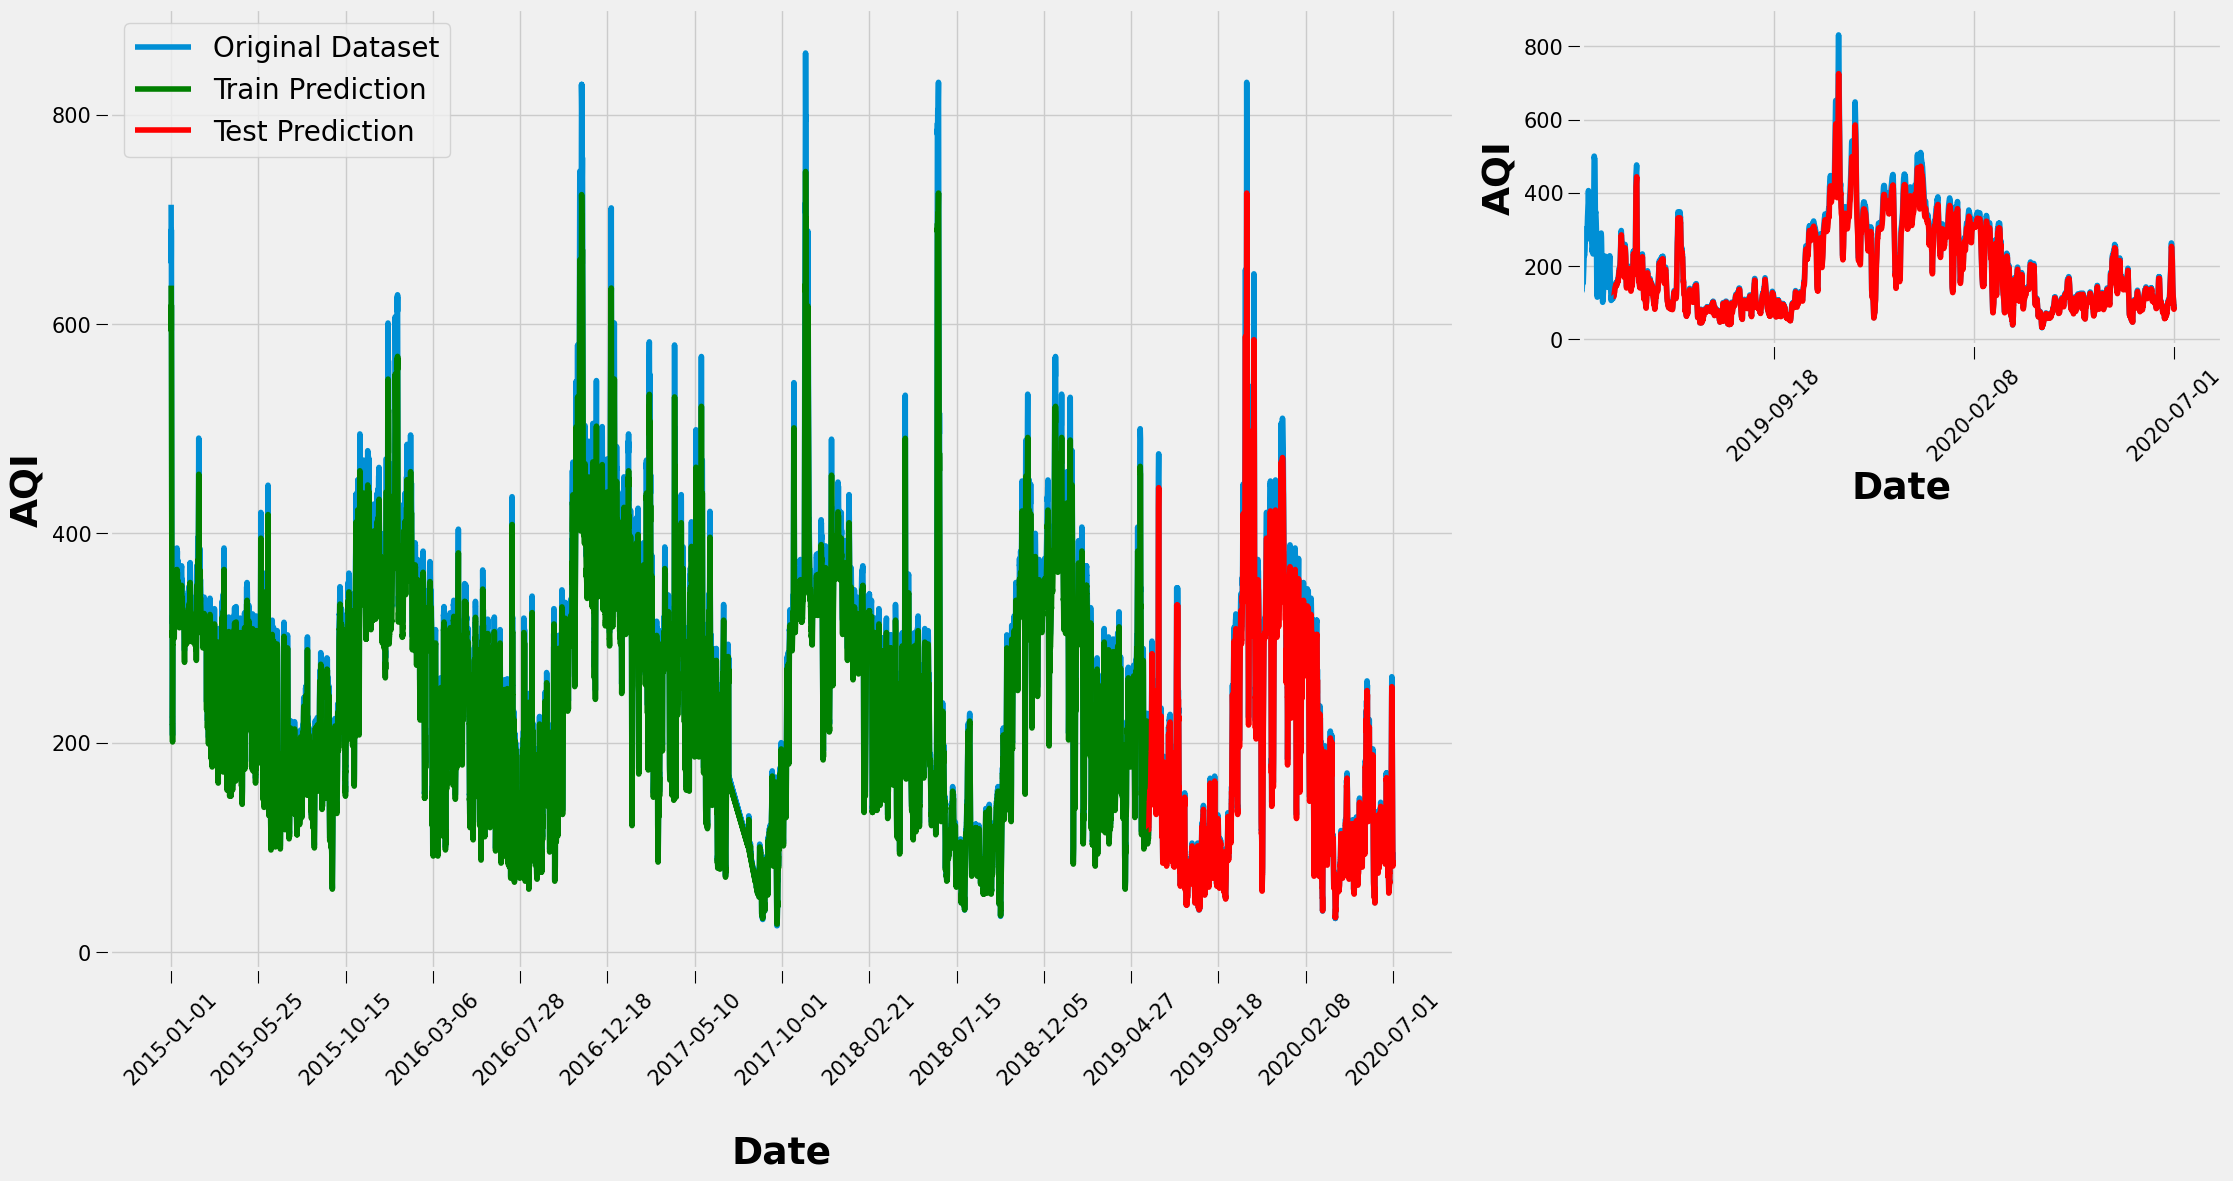

In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(aqi)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(aqi)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1 : len(aqi) - 1, :] = (
    testPredict
)

# plot original dataset and predictions
time_axis = np.linspace(0, aqi.shape[0] - 1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df2.index, dtype="datetime64[D]")

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(aqi), label="Original Dataset")
ax.plot(trainPredictPlot, color="green", label="Train Prediction")
ax.plot(testPredictPlot, color="red", label="Test Prediction")
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel("\nDate", fontsize=27, fontweight="bold")
ax.set_ylabel("AQI", fontsize=27, fontweight="bold")
ax.legend(loc="best", prop={"size": 20})
ax.tick_params(size=10, labelsize=15)
# ax.set_xlim([-1, 1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(aqi), label="Original Dataset")
ax1.plot(testPredictPlot, color="red", label="Test Prediction")
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel("Date", fontsize=27, fontweight="bold")
ax1.set_ylabel("AQI", fontsize=27, fontweight="bold")
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([38000, 49000])

## Other test

In [ ]:
plt.figure(figsize=(16,6))
plt.title('AQI')
plt.plot(df2['AQI_calculated'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['AQI_calculated'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [ ]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model2.fit(x_train, y_train, batch_size=1, epochs=1)

In [ ]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model2.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# make predictions
trainPredict = model2.predict(x_train)
testPredict = model2.predict(x_test)

# invert predictions
trainPredict = np.expm1(trainPredict)
y_train = np.expm1(y_train)
testPredict = np.expm1(testPredict)
y_test = np.expm1(y_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
test_series = pd.Series(y_test)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('AQI Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.plot(train['AQI_calculated'])
plt.plot(valid[['AQI_calculated', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()